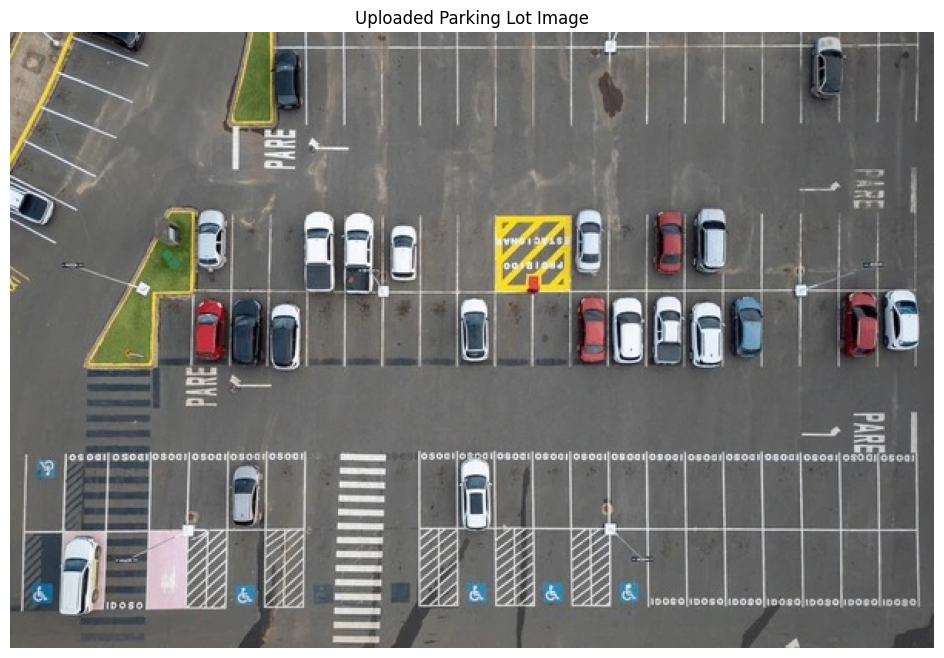

In [ ]:
# ✅ Cell 1 – Load and Display Image from File Path in Colab

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Replace this with the actual file name you upload to Colab
image_path = "/content/Original Image.jpeg"  # <-- update this!

# Load image
image = cv2.imread(image_path)

# Check and display
if image is not None:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title("Uploaded Parking Lot Image")
    plt.show()
else:
    print("❌ Image not found. Double-check the file name or path.")


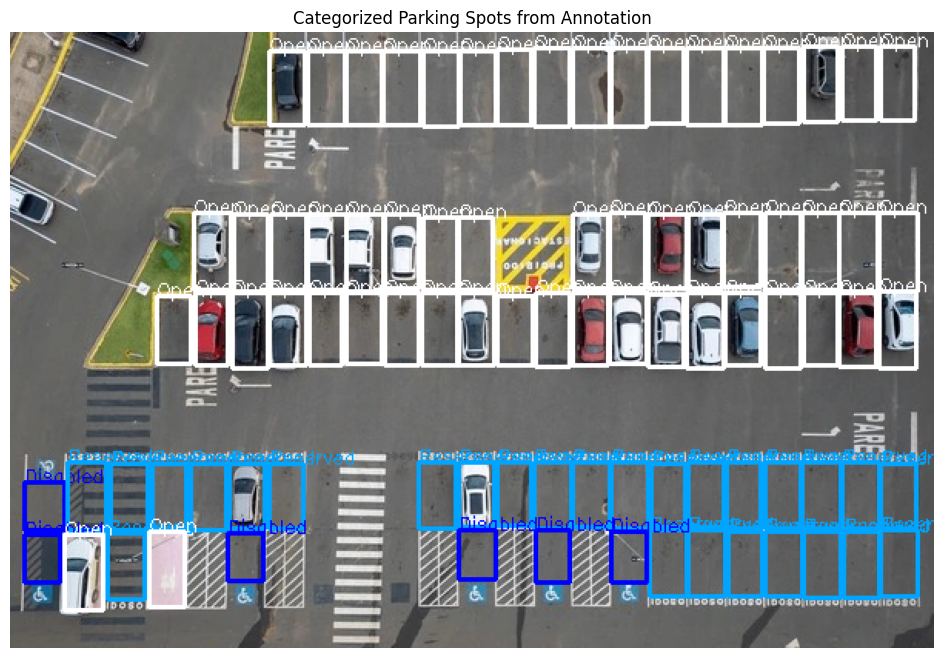

In [ ]:
# ✅ Cell 2 – Load annotation + draw parking spot boxes by category (from Pascal VOC)

import xml.etree.ElementTree as ET
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load image
image_path = "/content/Original Image.jpeg"  # Update if different
image = cv2.imread(image_path)

# Parse Pascal VOC XML
xml_path = "/content/Original Image Annotated.xml"  # Upload alongside image
tree = ET.parse(xml_path)
root = tree.getroot()

parsed_spots = []
for obj in root.findall("object"):
    label = obj.find("name").text
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    polygon = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    parsed_spots.append((polygon, label))

# Draw boxes
category_colors = {"Disabled": (255, 0, 0), "Reserved": (255, 165, 0), "Regular": (0, 255, 0)}
overlay_image = image.copy()

for i, (polygon, label) in enumerate(parsed_spots):
    color = category_colors.get(label, (255, 255, 255))
    cv2.polylines(overlay_image, [polygon], isClosed=True, color=color, thickness=2)
    cv2.putText(overlay_image, label, tuple(polygon[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

# Show result
rgb_overlay = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(rgb_overlay)
plt.axis('off')
plt.title("Categorized Parking Spots from Annotation")
plt.show()

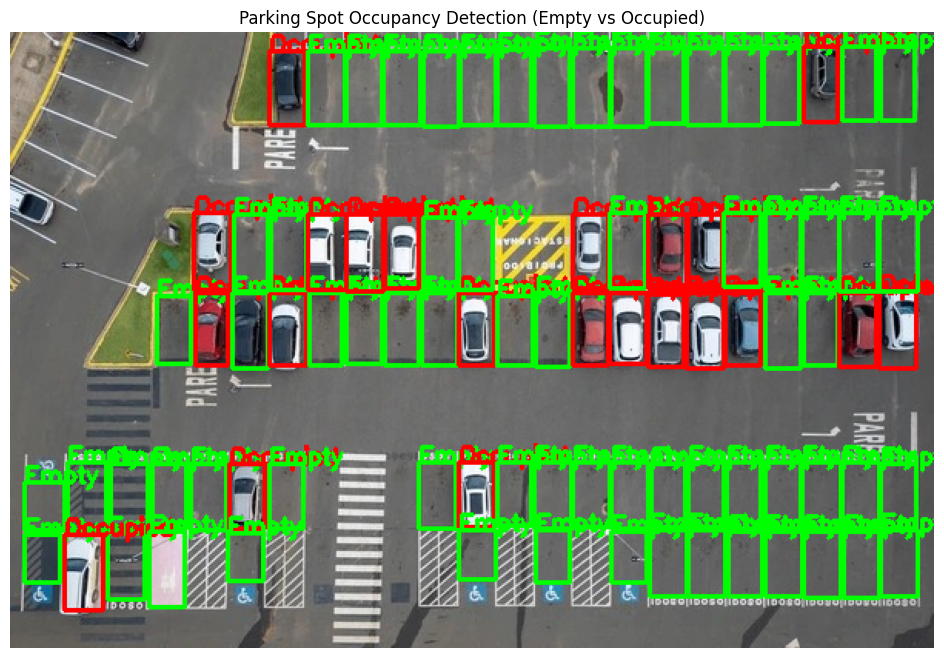

In [ ]:
# ✅ Cell 3 – Classify Each Parking Spot as Occupied or Empty

occupied_threshold = 26  # Tune this if needed (20–25 usually works well)
occupancy_status = []    # Store (polygon, label, is_occupied) for each

# Clone image for drawing results
occupancy_overlay = image.copy()

for polygon, label in parsed_spots:
    # Convert polygon to bounding box
    xmin = min(p[0] for p in polygon)
    xmax = max(p[0] for p in polygon)
    ymin = min(p[1] for p in polygon)
    ymax = max(p[1] for p in polygon)

    # Crop the parking spot region
    slot_crop = image[ymin:ymax, xmin:xmax]

    # Convert to grayscale and compute pixel intensity std deviation
    gray_crop = cv2.cvtColor(slot_crop, cv2.COLOR_BGR2GRAY)
    std_dev = np.std(gray_crop)

    # Decide occupancy
    is_occupied = std_dev > occupied_threshold
    status_text = "Occupied" if is_occupied else "Empty"
    box_color = (0, 0, 255) if is_occupied else (0, 255, 0)  # Red vs Green

    # Save for future use
    occupancy_status.append((polygon, label, is_occupied))

    # Draw result on overlay image
    cv2.polylines(occupancy_overlay, [polygon], isClosed=True, color=box_color, thickness=2)
    cv2.putText(occupancy_overlay, status_text, tuple(polygon[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)

# Show final result
rgb_occupancy = cv2.cvtColor(occupancy_overlay, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 8))
plt.imshow(rgb_occupancy)
plt.axis('off')
plt.title("Parking Spot Occupancy Detection (Empty vs Occupied)")
plt.show()


In [ ]:
# --- Install Libraries ---
!pip install -q ultralytics opencv-python paddleocr paddlepaddle pandas matplotlib

# --- Import Libraries ---
from paddleocr import PaddleOCR
from ultralytics import YOLO
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━

/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# --- Initialize Models ---
ocr = PaddleOCR(use_angle_cls=True, lang='en')
model = YOLO('yolov5s.pt')  # YOLOv5 small model (fast)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:17<00:00, 221.42it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:17<00:00, 580.48it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:14<00:00, 146.75it/s]

[2025/04/28 08:56:12] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 137MB/s] 


In [ ]:
# Function to detect license plate
def detect_plate(image_path):
    results = model(image_path)
    # Extract bounding boxes
    boxes = results[0].boxes.xyxy
    return boxes

def detect_plate_characters(image_path):
    result = ocr.ocr(image_path, cls=True)

    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"OCR Result: {image_path}")
    plt.show()

    # Step: keep each small word, even single characters and dots
    print(f"🔍 Raw Detection from {image_path}:")
    characters = []
    for line in result[0]:
        text = line[1][0]
        confidence = line[1][1]
        print(f"→ '{text}' | Confidence: {confidence:.2f}")
        if len(text.strip()) <= 6:  # keep short words
            characters.append((text.strip(), confidence))

def recognize_text_from_image(image_path):
    results = ocr.ocr(image_path, cls=True)
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    plate_texts = []
    cropped_regions = []

    for line in results[0]:
        box = line[0]
        text = line[1][0]
        conf = line[1][1]

        # Basic formatting
        cleaned = text.strip().upper().replace(" ", "")
        has_letters = any(c.isalpha() for c in cleaned)
        has_digits = any(c.isdigit() for c in cleaned)

        # Find center of bounding box
        box_center_x = sum([pt[0] for pt in box]) / 4
        box_center_y = sum([pt[1] for pt in box]) / 4

        is_near_center = (w*0.25 < box_center_x < w*0.75) and (h*0.3 < box_center_y < h*0.8)

        if (
            conf > 0.6 and
            5 <= len(cleaned) <= 8 and
            has_letters and has_digits and
            is_near_center
        ):
            x1 = int(min([pt[0] for pt in box]))
            y1 = int(min([pt[1] for pt in box]))
            x2 = int(max([pt[0] for pt in box]))
            y2 = int(max([pt[1] for pt in box]))

            cropped = img[y1:y2, x1:x2]
            cropped_regions.append(cropped)
            plate_texts.append(cleaned)

    return plate_texts, cropped_regions

def show_cropped_plates_with_text(cropped_images, plate_texts):
    for idx, (img, text) in enumerate(zip(cropped_images, plate_texts)):
        plt.figure(figsize=(6, 3))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Plate: {text}", fontsize=12)
        plt.axis("off")
        plt.show()

In [ ]:
import pandas as pd

# Load your Excel file with registered vehicles
df_registered = pd.read_excel("/content/Vehicle_Database.xlsx")
df_registered["License Plate"] = df_registered["License Plate"].astype(str).str.upper().str.strip()


[2025/04/28 09:05:48] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.22248435020446777
[2025/04/28 09:05:48] ppocr DEBUG: cls num  : 3, elapsed : 0.013587474822998047
[2025/04/28 09:05:48] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18303370475769043


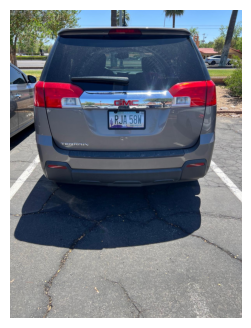

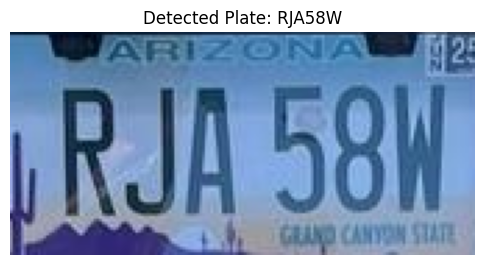

✅Detected License Plate:RJA58W 
❌ Plate 'RJA58W' is NOT REGISTERED — FINE ISSUED


In [ ]:


# Change this to any of your uploaded plate images
image_file = '/content/6.jpeg'

plate_texts, cropped_images = recognize_text_from_image(image_file)


# Display the original uploaded image
img_original = cv2.imread(image_file)
plt.figure(figsize=(8, 4))
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title("", fontsize=12)
plt.axis("off")
plt.show()


if plate_texts:
    # Take only the best match (first one is usually most confident)
    best_plate = plate_texts[0]
    best_image = cropped_images[0]

    # Show cropped image of the best candidate
    plt.figure(figsize=(6, 3))
    plt.imshow(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Plate: {best_plate}", fontsize=12)
    plt.axis("off")
    plt.show()

    print(f"✅Detected License Plate:{best_plate} ")

    # Check against the registration database
    if best_plate in df_registered["License Plate"].values:
        print(f"✅Plate '{best_plate}' is REGISTERED — No Fine")
    else:
        print(f"❌ Plate '{best_plate}' is NOT REGISTERED — FINE ISSUED")
else:
    print("❌ No license plate detected.")